# Forecasting Series Tiempo

## Contexto

**Objetivo:**:  Mejorar la toma de decisiones, optimizar recursos y brindar una experiencia superior a los clientes.

**Necesidad:** Anticipar las ventas de los próximos 30 días para evitar problemas de inventario.

**Problema a resolver:** ¿Cómo anticipar las ventas futuras para tomar decisiones acertadas sobre inventarios y recursos, reduciendo el impacto de los períodos de alta y baja demanda?

## Comprensión de los datos

### Exploración y preprocesamiento inicial

Comenzamos importando bibliotecas básicas y definiendo constantes como rutas

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = os.path.join('..', '..', 'data', 'input', 'forecasting')

In [3]:
df_features = pd.read_csv(os.path.join(DATA_PATH, 'features.csv'))
df_stores = pd.read_csv(os.path.join(DATA_PATH, 'stores.csv'))
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

In [4]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
raw_data = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_stores, on=['Store'], how='inner')
raw_data.drop(['IsHoliday_y'], axis=1,inplace=True)
raw_data.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)
raw_data.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [8]:
data = raw_data.copy(deep=True)

In [9]:
data.shape

(421570, 16)

In [10]:
data["Store"].nunique(), data["Dept"].nunique()

(45, 81)

Vemos que hay 45 tiendas y 81 departamentos

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [12]:
data["Date"] = pd.to_datetime(data["Date"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

Tenemos: 
- 1 variable booleana
- 1 variable categórica
- 1 variable temporal
- 13 variables numéricas; 10 continuas y 3 discretas

In [13]:
(data.isnull().sum() / data.shape[0]).sort_values(ascending=False)

MarkDown2       0.736110
MarkDown4       0.679847
MarkDown3       0.674808
MarkDown1       0.642572
MarkDown5       0.640790
Store           0.000000
Date            0.000000
Dept            0.000000
Fuel_Price      0.000000
Temperature     0.000000
IsHoliday       0.000000
Weekly_Sales    0.000000
CPI             0.000000
Unemployment    0.000000
Type            0.000000
Size            0.000000
dtype: float64

Podemos observar que las variables "Markdown" contienen un alto porcentaje de valores nulos, por lo que son buenas opciones para ser eliminadas.

In [14]:
data.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1, inplace=True)

In [15]:
data["Date"].min(), data["Date"].max()

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

Tenemos datos de casi 2 años y 9 meses.

In [16]:
data.describe()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,171.201947,7.960289,136727.915739
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,227.232807,14.313000,219622.000000
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,39.159276,1.863296,60980.583328


Observamos que por ejemplo hay ventas negativas, lo cual no tiene sentido.

In [17]:
data[data["Weekly_Sales"] < 0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
846,1,6,2012-08-10,-139.65,False,85.05,3.494,221.958433,6.908,A,151315
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,221.671800,7.143,A,151315
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,211.289143,8.106,A,151315
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,211.380643,8.106,A,151315
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,211.746754,7.838,A,151315
...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,181.982317,8.992,B,118221
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,182.034782,8.992,B,118221
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,181.692477,8.899,B,118221
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,182.318780,8.743,B,118221


Estos datos podrían ser errores de transcripción, pero como solo representan menos del 0.3%, mejor prescindiremos de ellos.

In [18]:
data = data[data["Weekly_Sales"] >= 0]
data.describe()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
count,420285.000000,420285.000000,420285,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000
mean,22.195477,44.242771,2011-06-18 07:22:30.395088640,16030.329773,60.090474,3.360888,171.212152,7.960077,136749.569176
min,1.000000,1.000000,2010-02-05 00:00:00,0.000000,-2.060000,2.472000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2117.560000,46.680000,2.933000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7659.090000,62.090000,3.452000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20268.380000,74.280000,3.738000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,227.232807,14.313000,219622.000000
std,12.787213,30.507197,NaN,22728.500149,18.448260,0.458523,39.162280,1.863873,60992.688568


Podemos observar que:

- **Ventas semanales:** Promedio de 16030, con una alta desviación estándar de 22728

Analicemos cómo se comportan las ventas por tienda y por departamento.

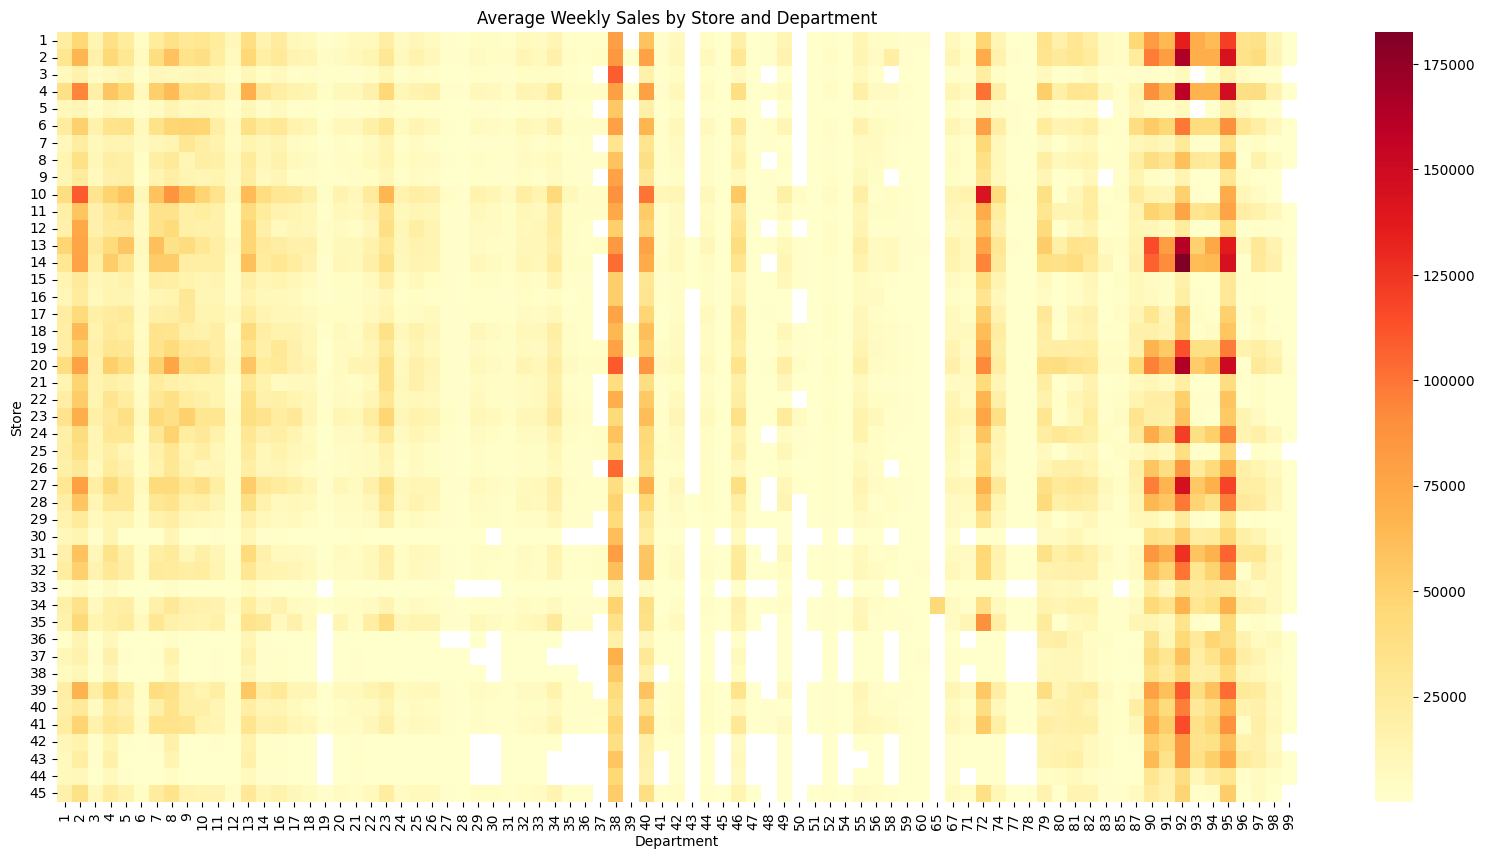

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.pivot_table(data, index='Store', columns='Dept', values='Weekly_Sales', aggfunc="mean"),
			cmap='YlOrRd',
			annot=False)
plt.title('Average Weekly Sales by Store and Department')
plt.xlabel('Department')
plt.ylabel('Store')
plt.show()

Parece que las ventas están más relacionadas con el departamento que con la tienda: la gran mayoría de tiendas, en los departamentos entre el 90 al 95 presentan unos grandes promedios de ventas semanales.

Observemos a continuación cuáles son las tiendas con mayores ventas.

In [20]:
data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)

Store
20    3.014014e+08
4     2.995453e+08
14    2.890019e+08
13    2.865180e+08
2     2.753872e+08
10    2.716241e+08
27    2.538572e+08
6     2.237586e+08
1     2.224068e+08
39    2.074465e+08
Name: Weekly_Sales, dtype: float64

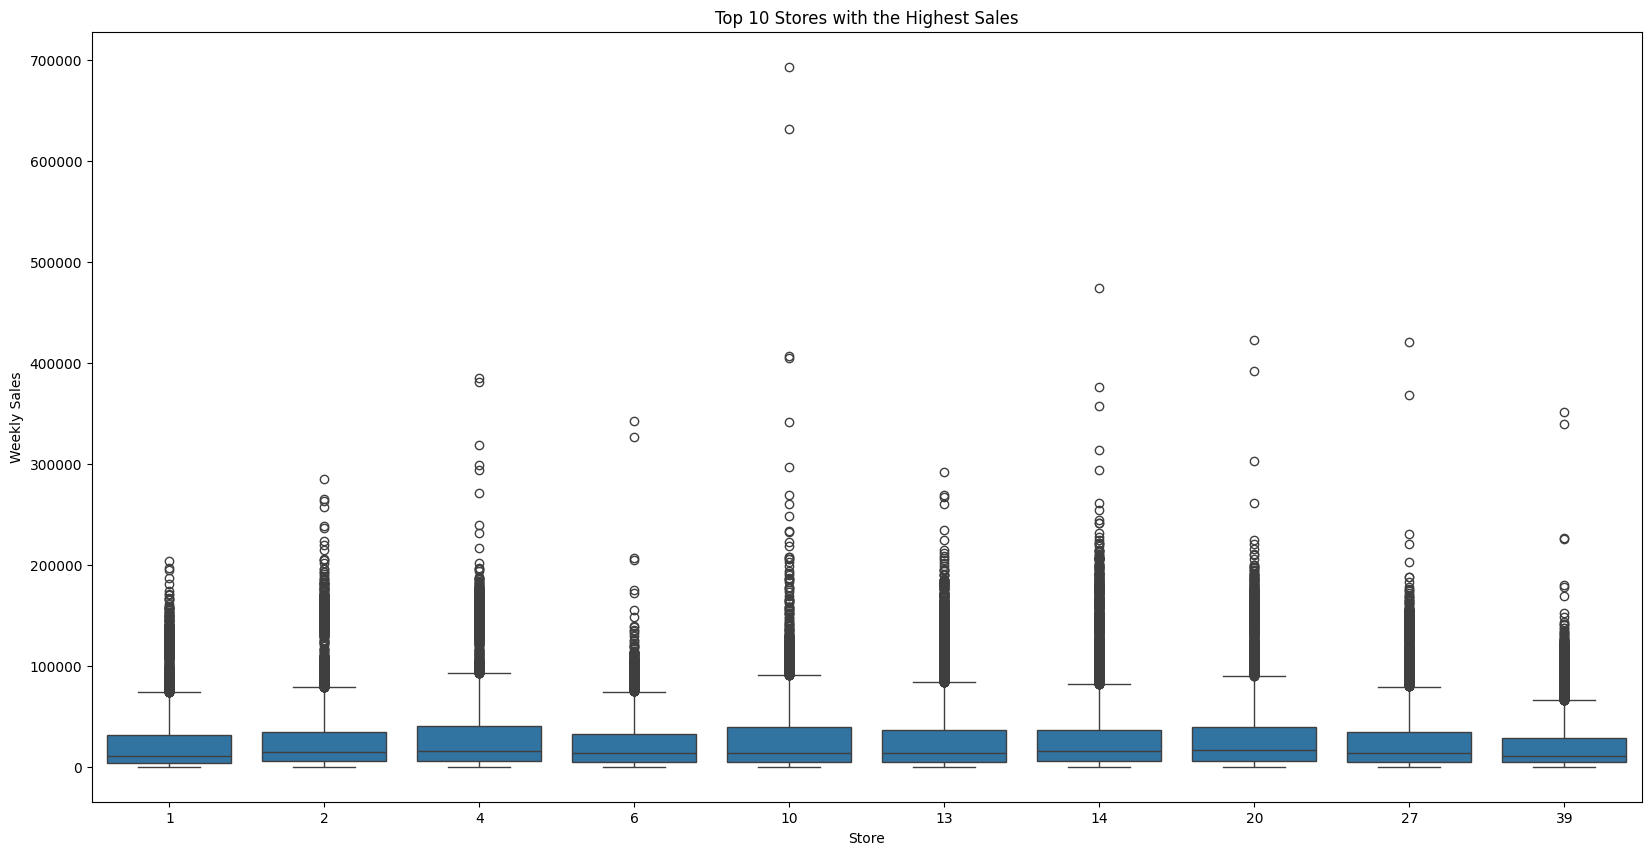

In [21]:
plt.figure(figsize=(20,10))
top_stores = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
top_stores = data[data['Store'].isin(top_stores.index)]
sns.boxplot(x='Store', y='Weekly_Sales', data=top_stores)
plt.title('Top 10 Stores with the Highest Sales')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.show()

El promedio de ventas de estas tiendas, en general, es bastante parecido.

Hagamos ahora lo propio con los departamentos

In [22]:
data.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)

Dept
92    4.839433e+08
95    4.493202e+08
38    3.931181e+08
72    3.057282e+08
90    2.910685e+08
40    2.889360e+08
2     2.806112e+08
91    2.167817e+08
13    1.973216e+08
8     1.942808e+08
Name: Weekly_Sales, dtype: float64

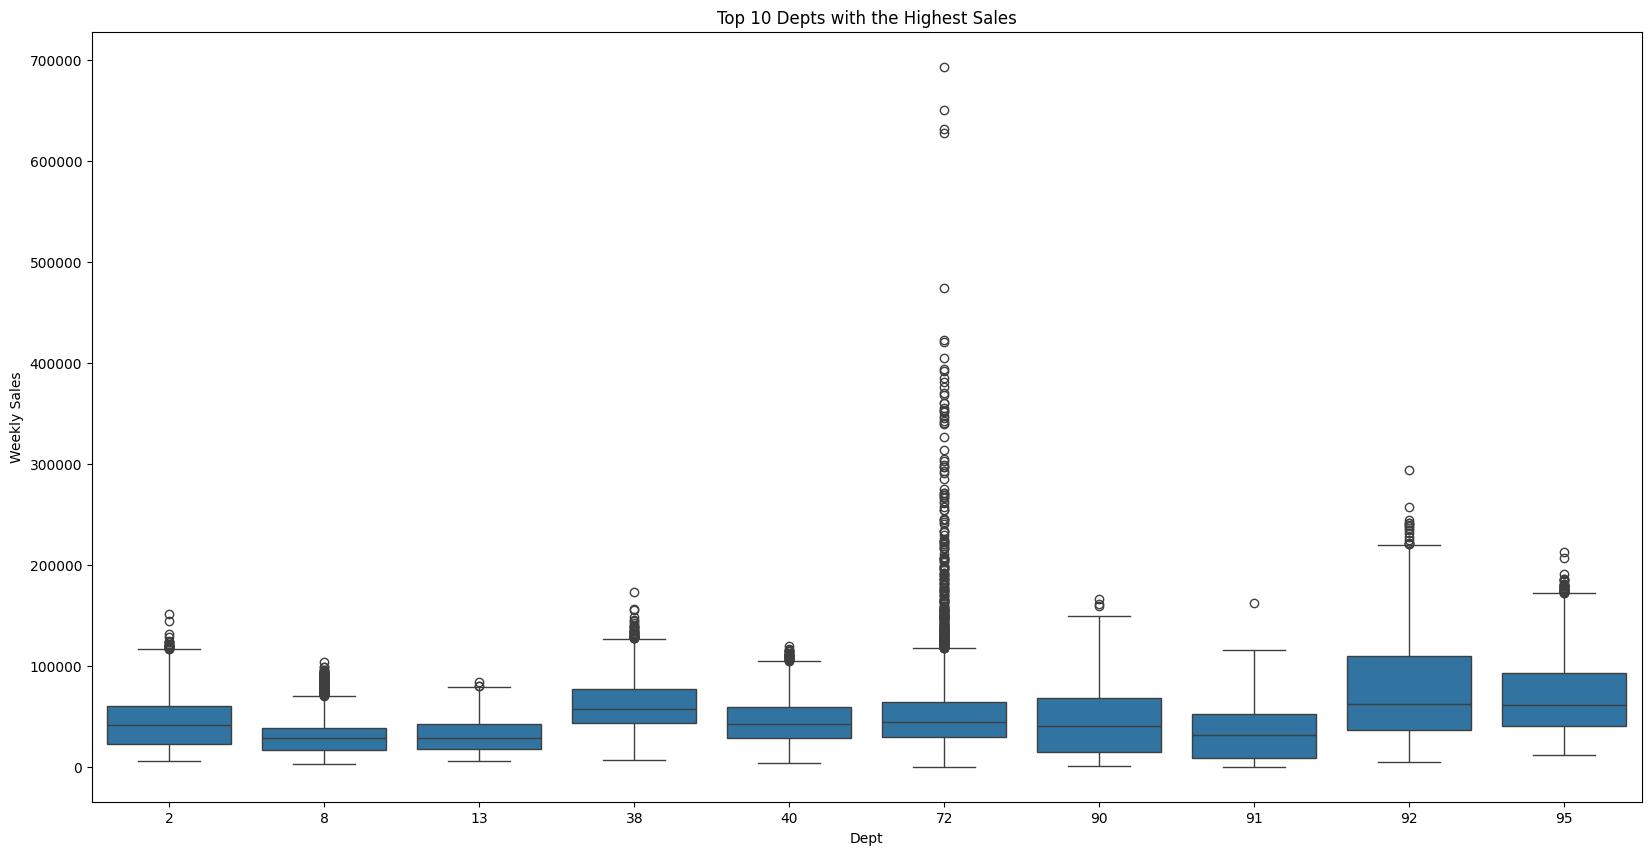

In [23]:
plt.figure(figsize=(20,10))
top_dept = data.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
top_dept = data[data['Dept'].isin(top_dept.index)]
sns.boxplot(x='Dept', y='Weekly_Sales', data=top_dept)
plt.title('Top 10 Depts with the Highest Sales')
plt.xlabel('Dept')
plt.ylabel('Weekly Sales')
plt.show()

Con los departamentos podemos visualizar que sí hay diferencias significativas entre sus promedios de ventas; siendo los departamentos 92 y 95 los que presentan mayores beneficios.

Ahora analicemos las ventas en días festivos.

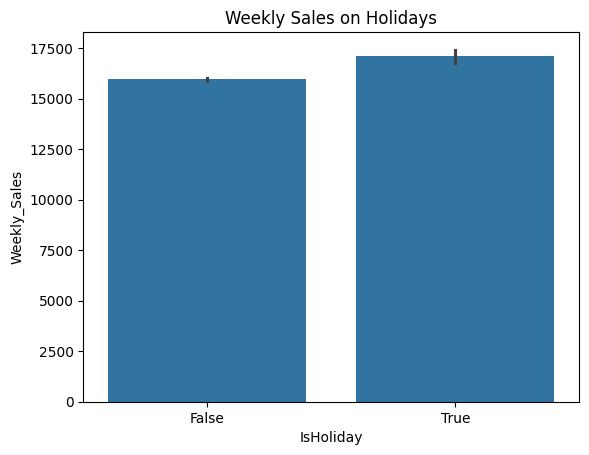

In [24]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=data)
plt.title('Weekly Sales on Holidays')
plt.show()

Podemos observar que en días festivos, en promedio, hay un poco más de ventas, aunque no demasiado.

Ahora investiguemos las ventas por el tipo de tienda.

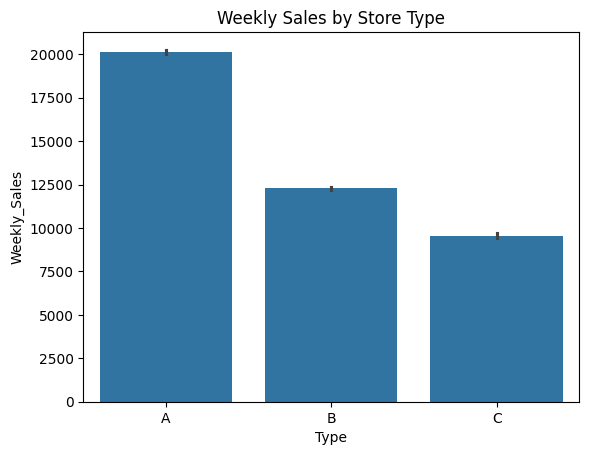

In [25]:
sns.barplot(x='Type', y='Weekly_Sales', data=data)
plt.title('Weekly Sales by Store Type')
plt.show()

Podemos evidenciar que hay una correlación entre el tipo de tienda y las ventas semanales. Esto puede deberse al tamaño de las tiendas.

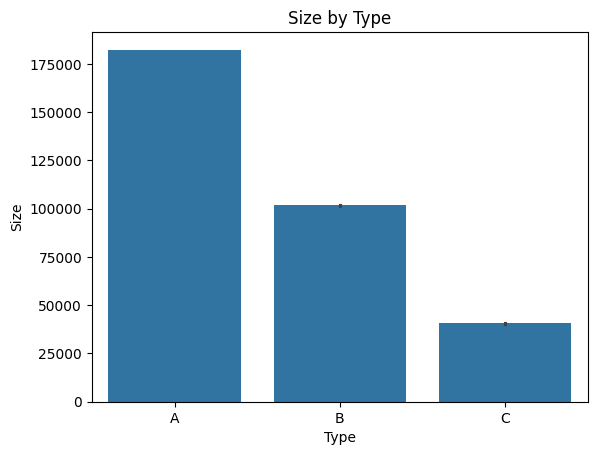

In [26]:
sns.barplot(x='Type', y="Size", data=data)
plt.title('Size by Type')
plt.show()

Efectivamente, los tipos de tienda con mayores ventas semanales también son las más grandes.

Comencemos ahora visualizando el comportamiento de las ventas a través del tiempo.

C:\Users\alexg\AppData\Local\Temp\ipykernel_6944\787414106.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Date', y='Weekly_Sales', data=data, ci=None)


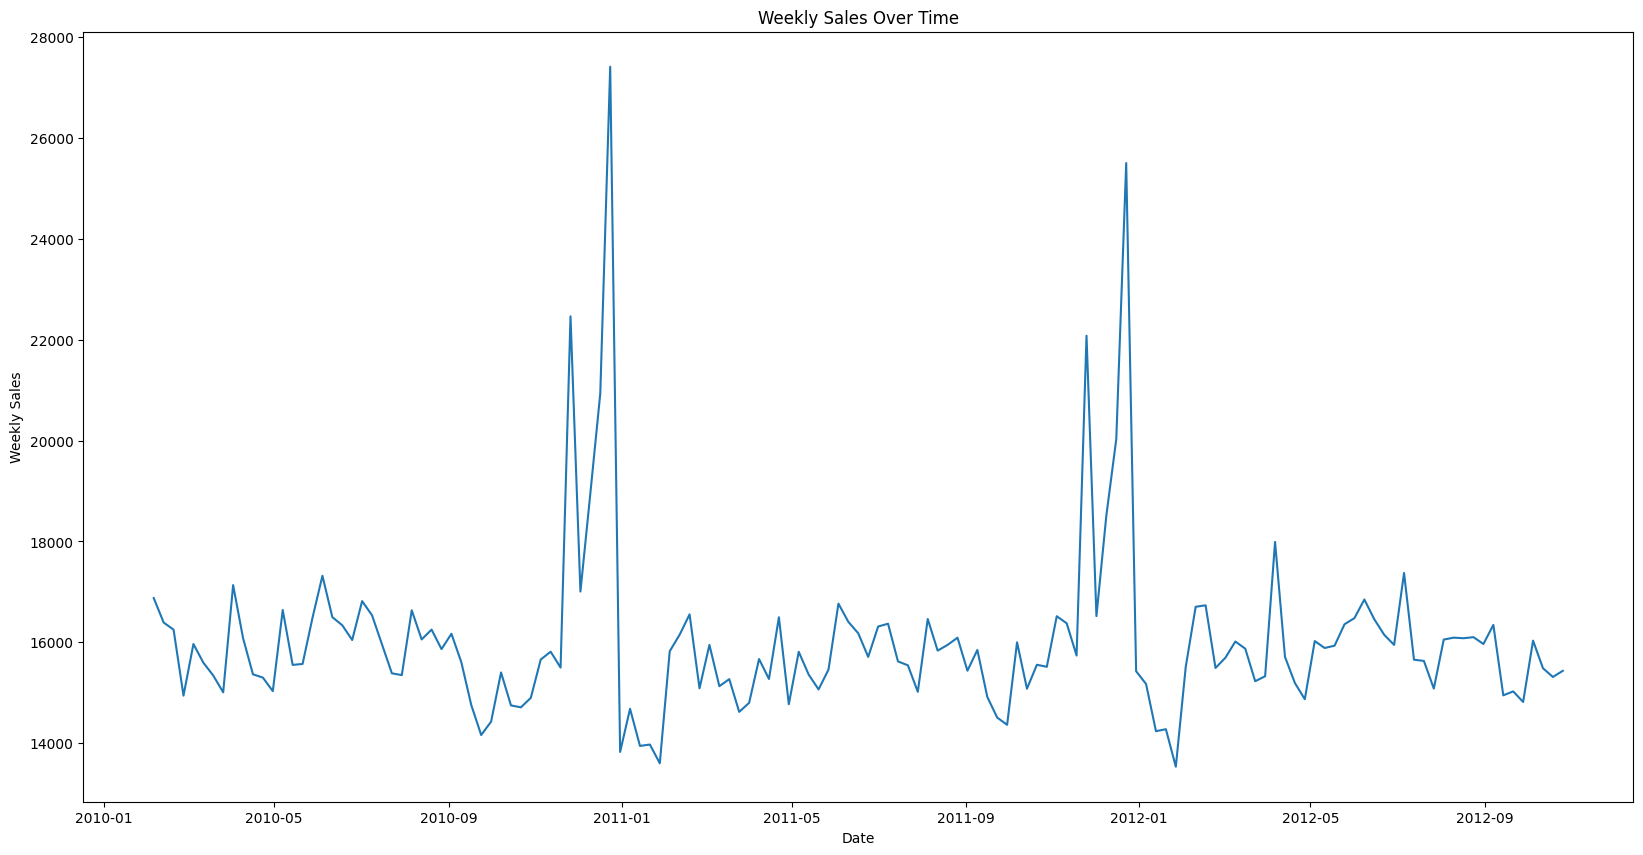

In [27]:
# Ventas a lo largo del tiempo
plt.figure(figsize=(20,10))
sns.lineplot(x='Date', y='Weekly_Sales', data=data, ci=None)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

A simple vista, la serie de ventas parece más o menos tener una estacionalidad, donde las ventas aumentan en los últimos meses del año y luego caen a inicios del siguiente; exploremos esto un poco más.

In [28]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

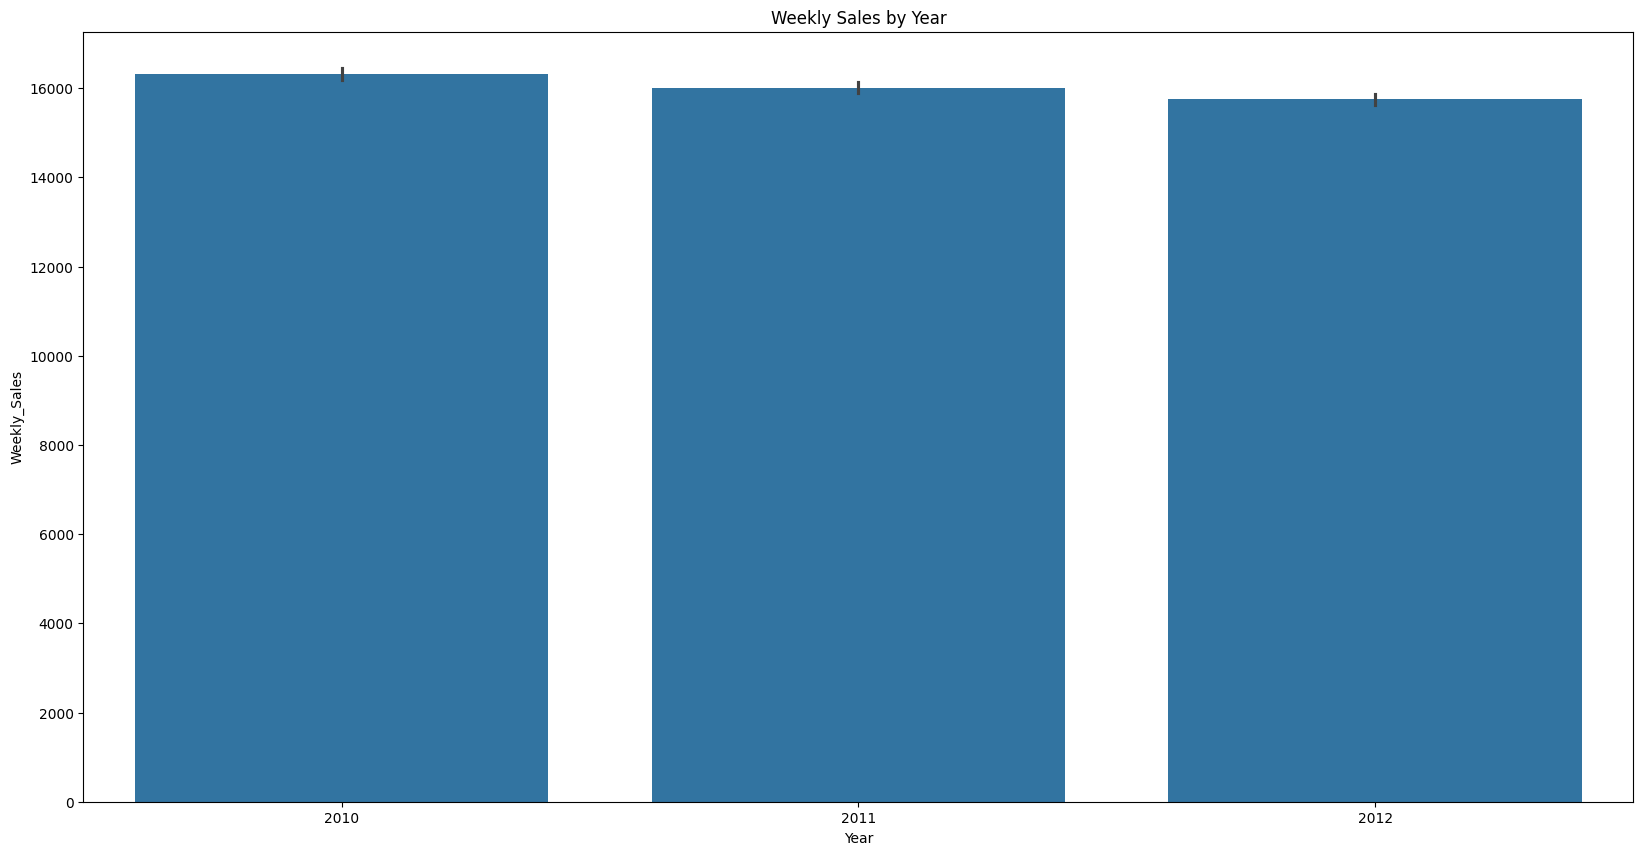

In [29]:
plt.figure(figsize=(20,10))
sns.barplot(x='Year', y='Weekly_Sales', data=data)
plt.title('Weekly Sales by Year')
plt.show()

Podemos percibir una leve tendencia a que las ventas disminuyan a través de los años, aunque no tenemos información de todo el 2012 como para poder afirmarlo.

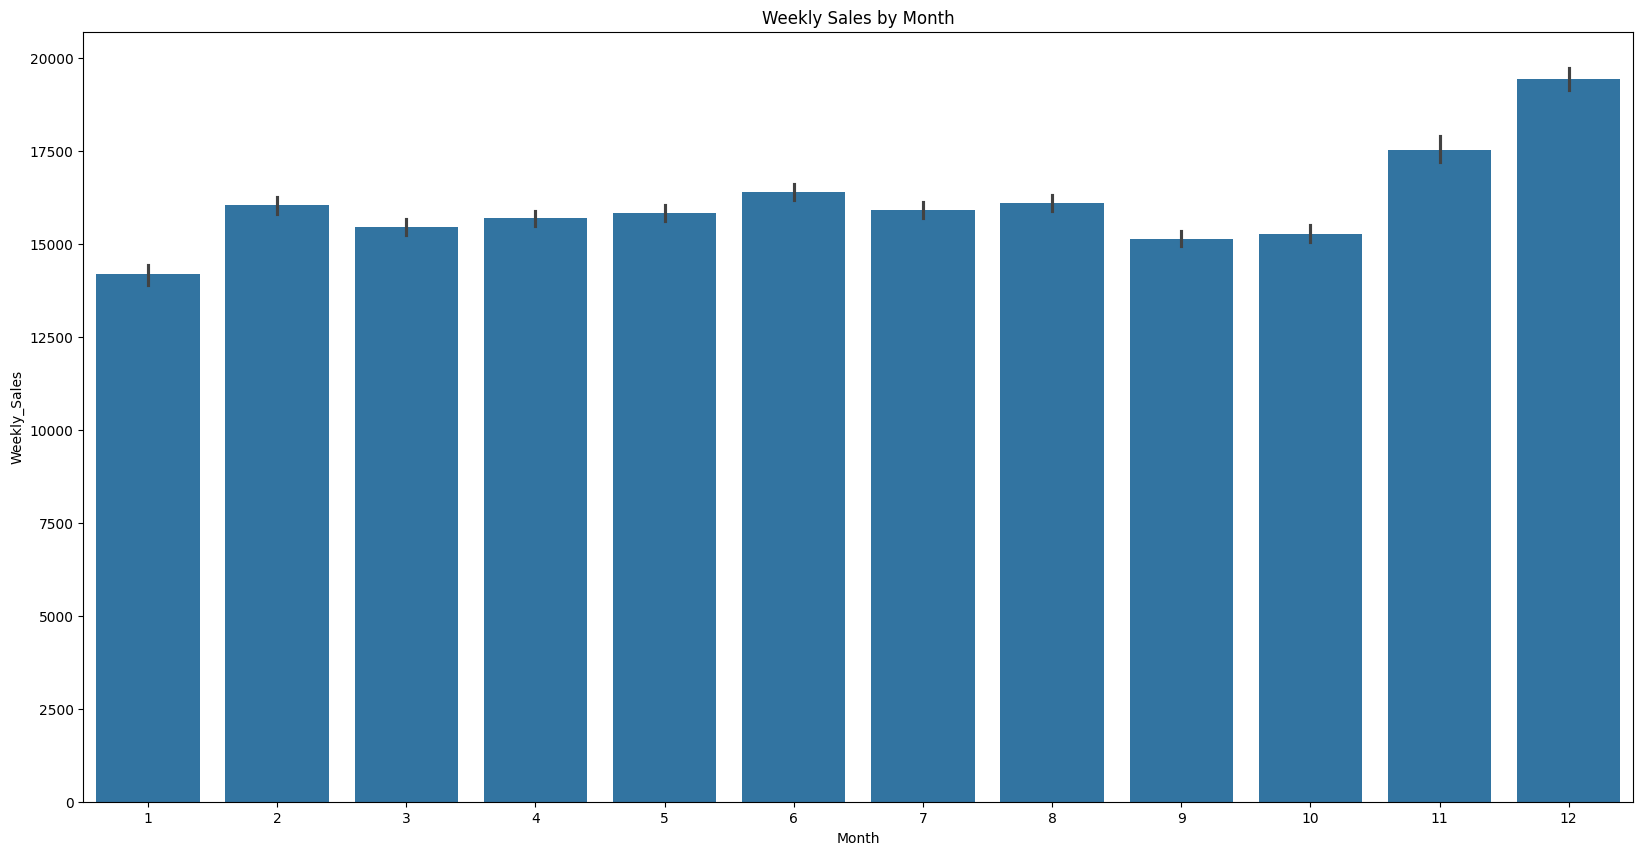

In [30]:
plt.figure(figsize=(20,10))
sns.barplot(x='Month', y='Weekly_Sales', data=data)
plt.title('Weekly Sales by Month')
plt.show()

C:\Users\alexg\AppData\Local\Temp\ipykernel_6944\3701067244.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Month', y='Weekly_Sales', hue='Year', data=data, ci=None)


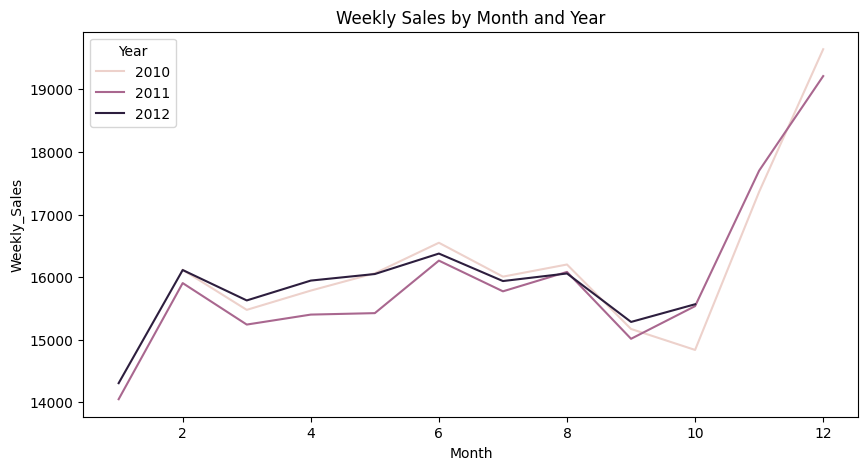

In [31]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Month', y='Weekly_Sales', hue='Year', data=data, ci=None)
plt.title('Weekly Sales by Month and Year')
plt.show()

Podemos ver que, en general, se mantiene durante los años que las ventas suben en los últimos 3 meses del año para luego caer en el primer mes del próximo año.

Exloremos cómo evolucionaron las ventas para algunas tiendas y algunos departamentos.

C:\Users\alexg\AppData\Local\Temp\ipykernel_6944\1738572077.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Date', y='Weekly_Sales', hue='Store', data=top_stores, ci=None)


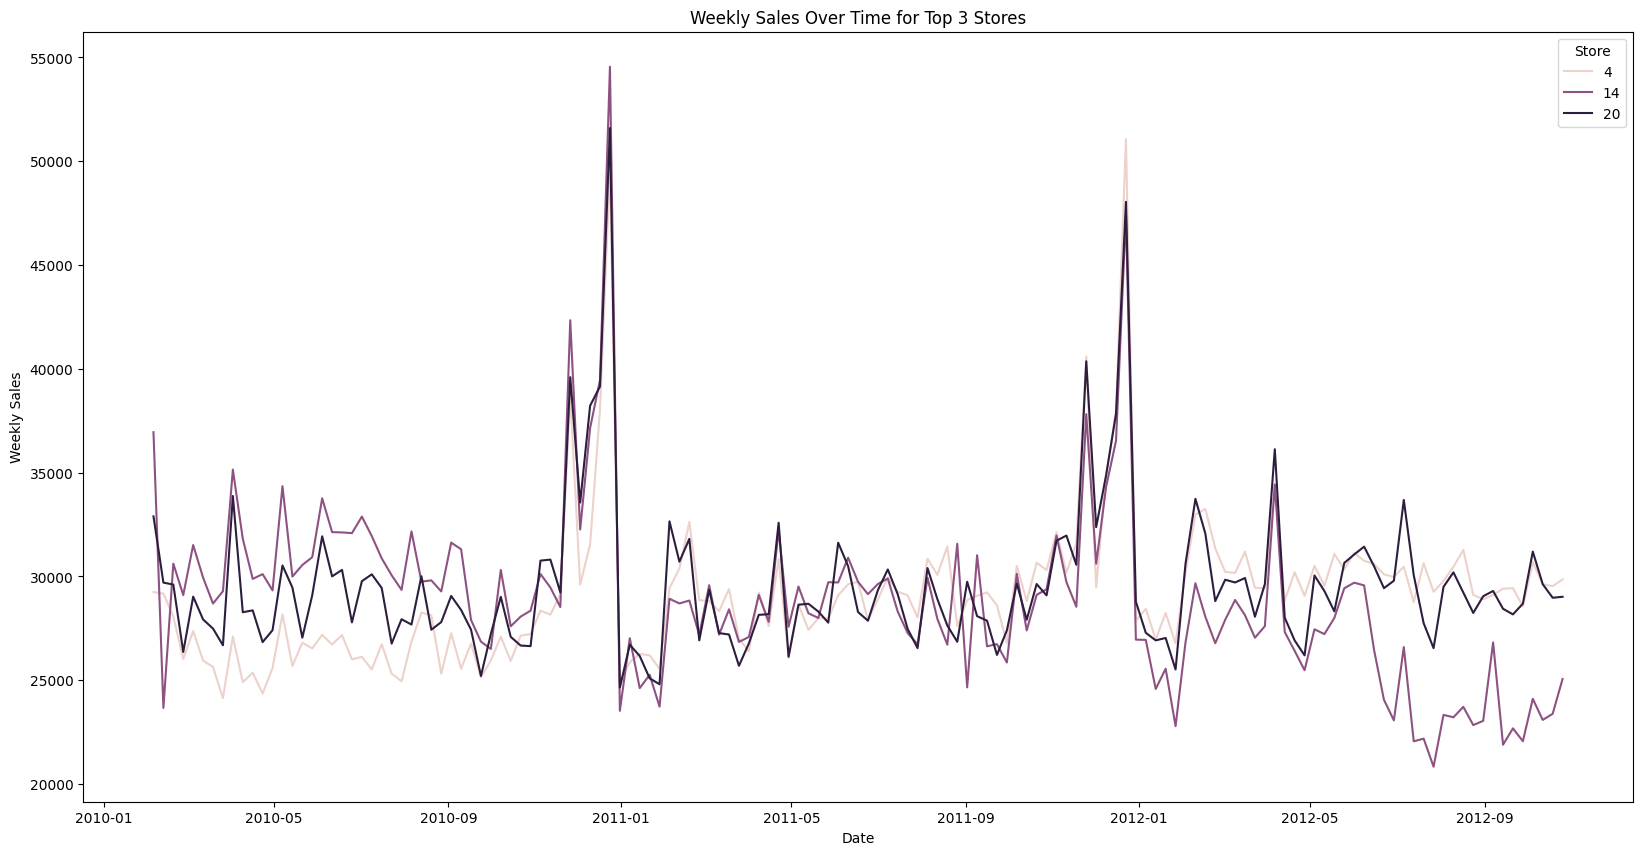

In [32]:
plt.figure(figsize=(20,10))
top_stores = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(3)
top_stores = data[data['Store'].isin(top_stores.index)]
sns.lineplot(x='Date', y='Weekly_Sales', hue='Store', data=top_stores, ci=None)
plt.title('Weekly Sales Over Time for Top 3 Stores')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

Podemos ver, que en general, su comportamiento es muy parecido, siendo diferentes en magnitud.

C:\Users\alexg\AppData\Local\Temp\ipykernel_6944\1488843949.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Date', y='Weekly_Sales', hue='Dept', data=top_dept, ci=None)


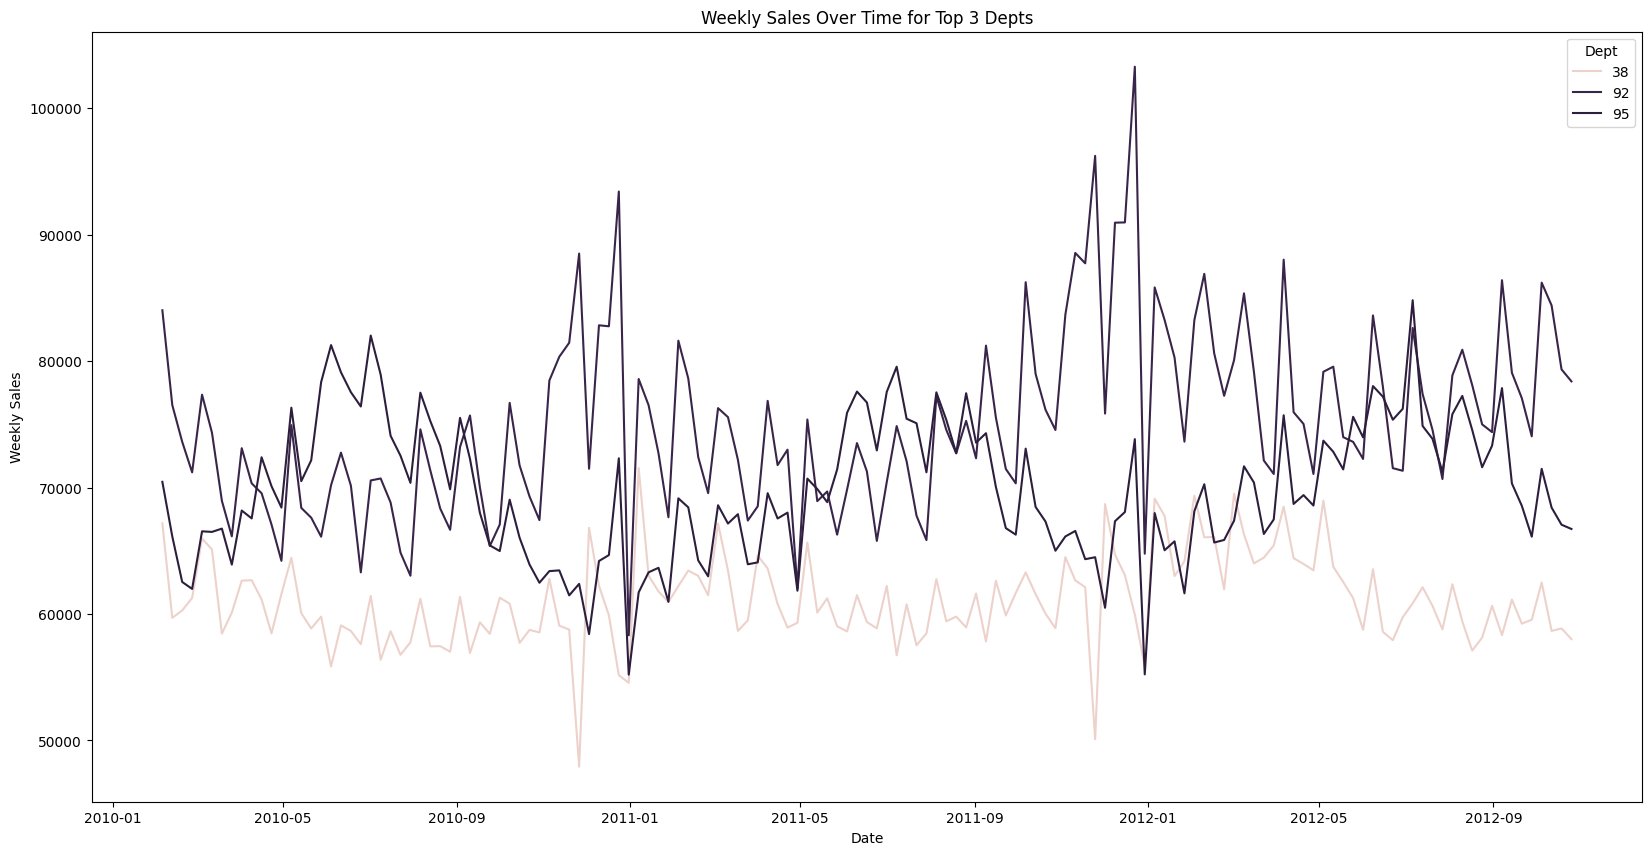

In [33]:
plt.figure(figsize=(20,10))
top_dept = data.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(3)
top_dept = data[data['Dept'].isin(top_dept.index)]
sns.lineplot(x='Date', y='Weekly_Sales', hue='Dept', data=top_dept, ci=None)
plt.title('Weekly Sales Over Time for Top 3 Depts')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

Las ventas sí parecen ser más diferentes dependiendo del departamento.

C:\Users\alexg\AppData\Local\Temp\ipykernel_6944\3046615854.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Date', y='Weekly_Sales', hue='Type', data=data, ci=None)


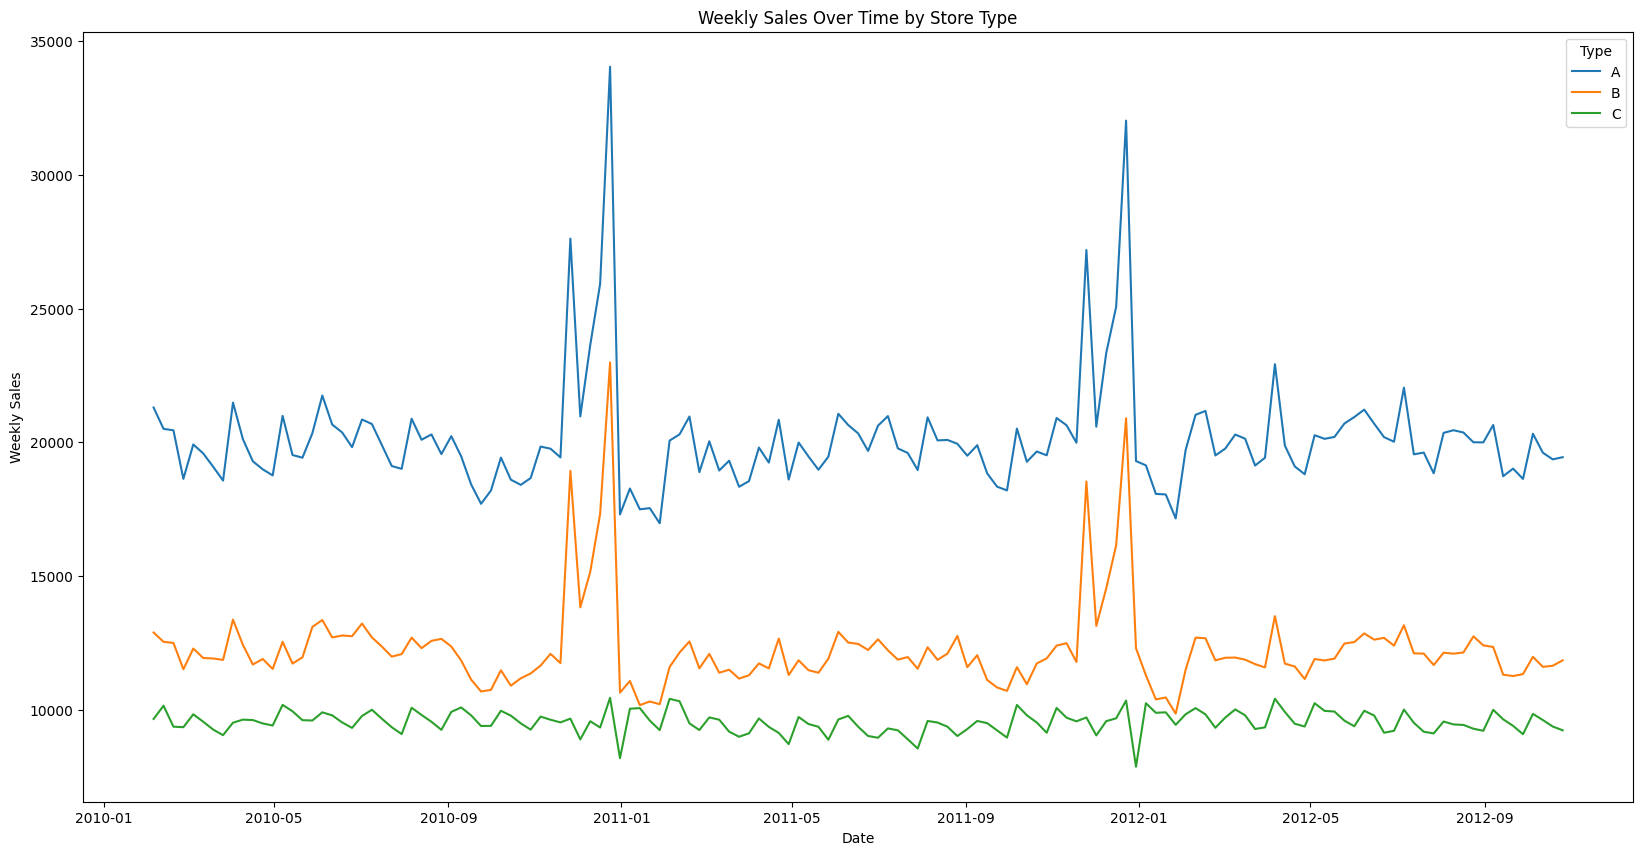

In [34]:
plt.figure(figsize=(20,10))
sns.lineplot(x='Date', y='Weekly_Sales', hue='Type', data=data, ci=None)
plt.title('Weekly Sales Over Time by Store Type')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

Y el tipo de tienda influye en la magnitud de las ventas pero no en su comportamiento general.

Procedamos a evaluar si las macrovariables influyen en las ventas.

<Axes: xlabel='CPI'>

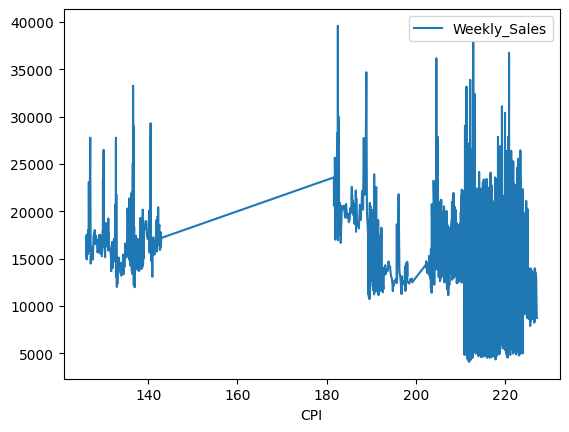

In [35]:
pd.pivot_table(data, values='Weekly_Sales', index='CPI').plot()

<Axes: xlabel='Fuel_Price'>

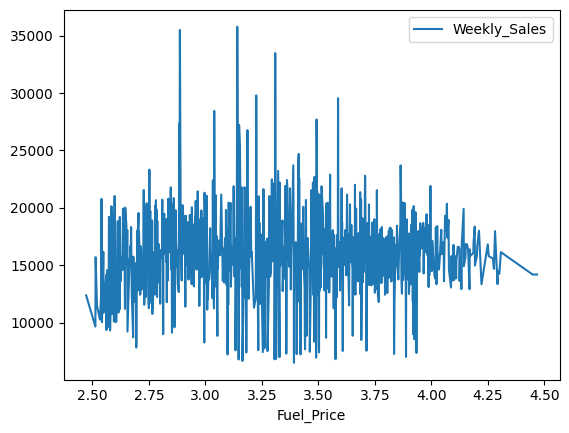

In [36]:
pd.pivot_table(data, values='Weekly_Sales', index='Fuel_Price').plot()

<Axes: xlabel='Unemployment'>

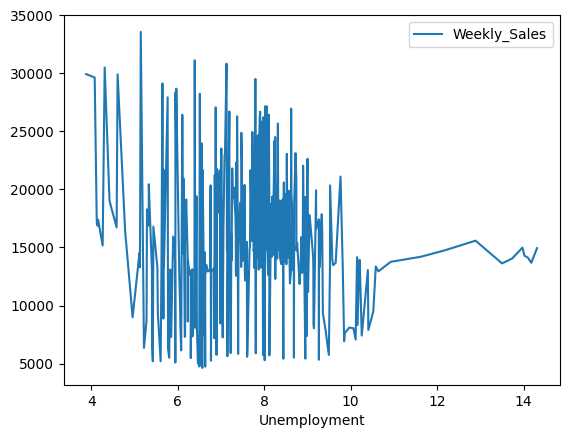

In [37]:
pd.pivot_table(data, values='Weekly_Sales', index='Unemployment').plot()

<Axes: xlabel='Temperature'>

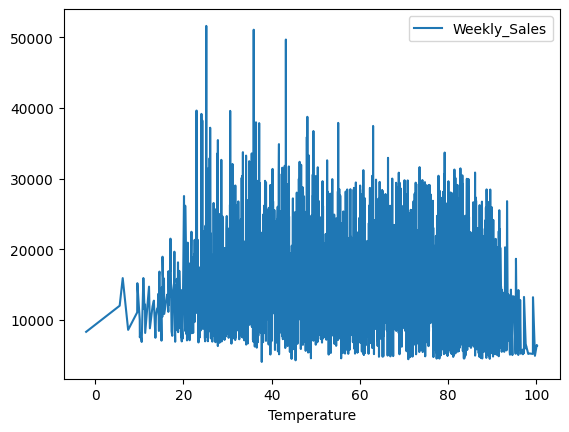

In [38]:
pd.pivot_table(data, values='Weekly_Sales', index='Temperature').plot()

No parece que exista relación entre las macrovariables y las ventas.

### Exploración de la Serie

Comencemos descomponiendo la serie

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(data.groupby('Date')['Weekly_Sales'].sum(), period=52)

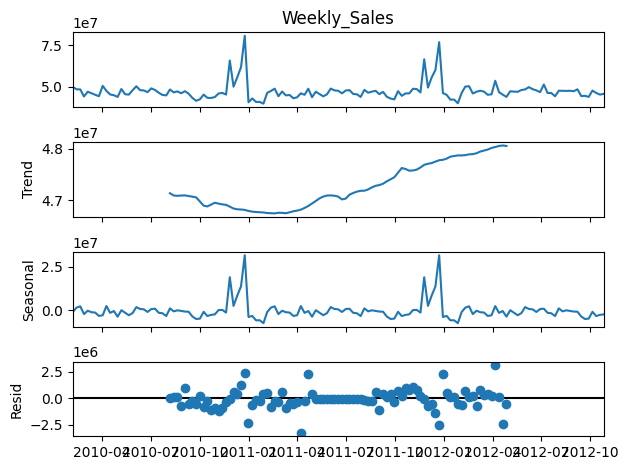

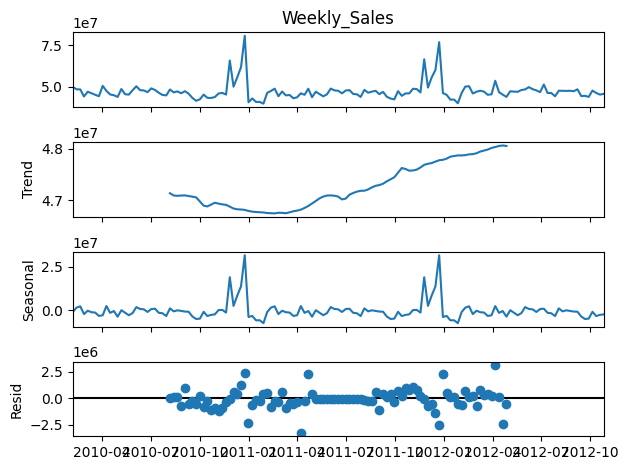

In [42]:
decompose_result.plot()

In [43]:
decompose_result.resid.mean()

np.float64(-75042.2986270368)

In [44]:
decompose_mult_result = seasonal_decompose(data.groupby('Date')['Weekly_Sales'].sum(), period=52, model='multiplicative')

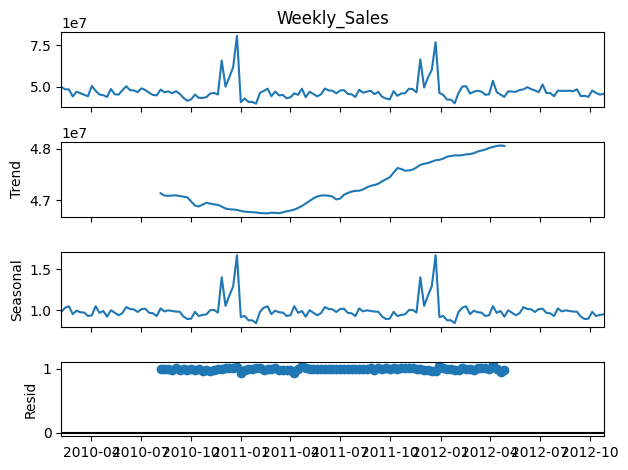

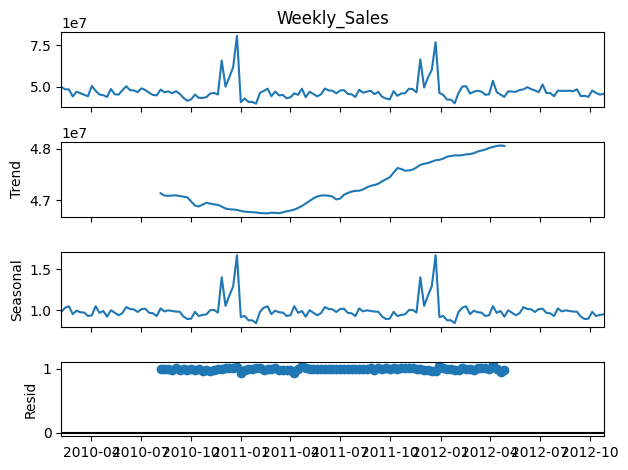

In [45]:
decompose_mult_result.plot()

In [46]:
decompose_mult_result.resid.mean()

np.float64(0.9983851493783358)

In [49]:
from statsmodels.tsa.seasonal import STL

stl = STL(data.groupby('Date')['Weekly_Sales'].sum(), period=52).fit()

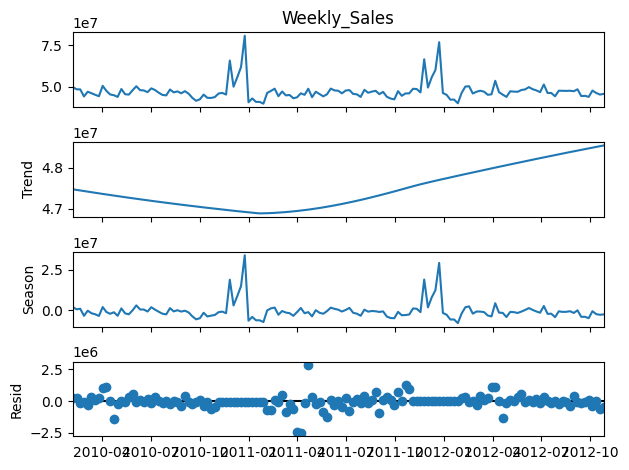

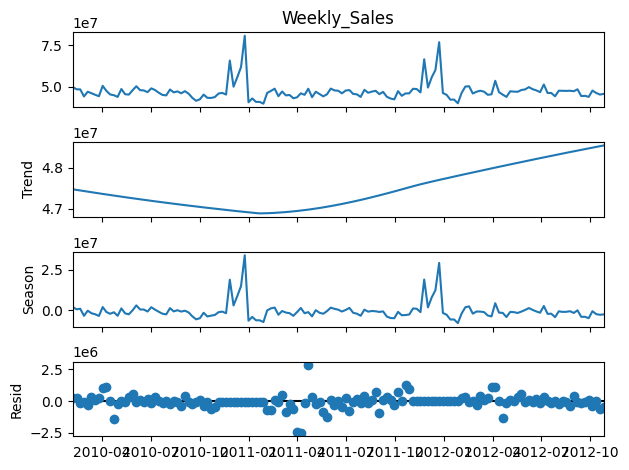

In [50]:
stl.plot()

In [51]:
stl.resid.mean()

np.float64(-40465.44382437365)

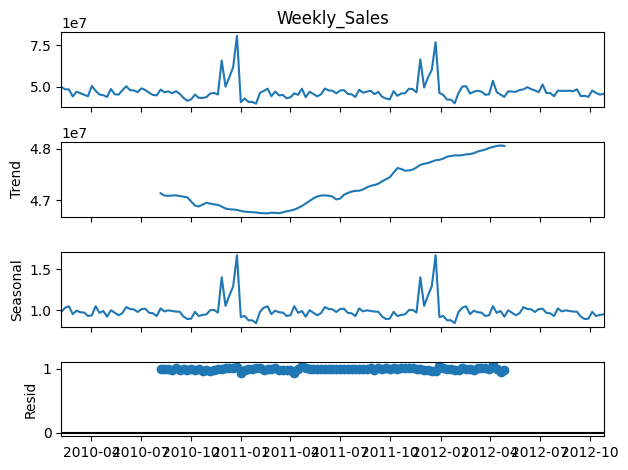

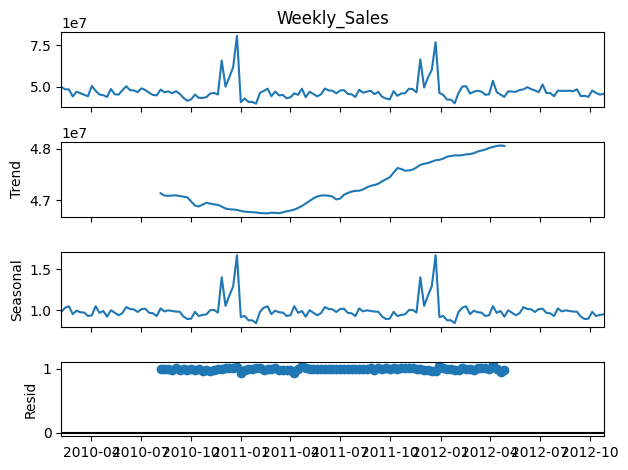

In [54]:
decompose_mult_result.plot()

A partir de la descomposición podemos observar que el mejor método es el método clásico con el modelo multiplicativo. También se observa que la tendencia de las ventas ha sido creciente y que parece existir una estacionalidad de un año.

Lo siguiente será verificar si la serie de tiempo es estacionaria usando la prueba de Dickey-Fuller.

In [55]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data.groupby('Date')['Weekly_Sales'].sum())
print('p-value:', result[1])

p-value: 2.674606788825824e-07


Como el valor p es menor a 0.05 entonces se rechaza la hipótesis nula de que la serie tiene una raíz unitaria; es decir, la serie es estacionaria.

In [56]:
data.to_csv(os.path.join(DATA_PATH, 'data_processed.csv'), index=False)